In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [60]:
data = pd.read_csv('train_modified.csv')

In [61]:
data.head()

,Id,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontagenan,MasVnrAreanan,GarageYrBltnan
0,1,12.247694,0.235294,0.75,0.418208,0.366344,1.0,1.0,0.000000,0.333333,...,1.0,1.0,0.0,0.090909,0.50,0.666667,0.75,0.0,0.0,0.0
1,2,12.109011,0.000000,0.75,0.495064,0.391317,1.0,1.0,0.000000,0.333333,...,1.0,1.0,0.0,0.363636,0.25,0.666667,0.75,0.0,0.0,0.0
2,3,12.317167,0.235294,0.75,0.434909,0.422359,1.0,1.0,0.333333,0.333333,...,1.0,1.0,0.0,0.727273,0.50,0.666667,0.75,0.0,0.0,0.0
3,4,11.849398,0.294118,0.75,0.388581,0.390295,1.0,1.0,0.333333,0.333333,...,1.0,1.0,0.0,0.090909,0.00,0.666667,0.00,0.0,0.0,0.0
4,5,12.429216,0.235294,0.75,0.513123,0.468761,1.0,1.0,0.333333,0.333333,...,1.0,1.0,0.0,1.000000,0.50,0.666667,0.75,0.0,0.0,0.0


In [62]:
X = data.drop(['Id','SalePrice'],axis=1)
y = data['SalePrice']

In [63]:
# Splitting dataset for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [64]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [65]:
### Apply Feature Selection
# first, I specify the Lasso Regression model, and I
# select a suitable alpha (equivalent of penalty).
# The bigger the alpha the less features that will be selected.

# Then I use the selectFromModel object from sklearn, which
# will select the features which coefficients are non-zero

feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0)) # remember to set the seed, the random state in this function
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [66]:
feature_sel_model.get_support()

array([ True,  True, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
        True,  True, False, False, False, False, False,  True, False,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False])

In [67]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feat = X_train.columns[(feature_sel_model.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(X_train.shape[1]-len(selected_feat)))

total features: 82
selected features: 25
features with coefficients shrank to zero: 57


In [68]:
selected_feat

Index(['MSSubClass', 'MSZoning', 'LotShape', 'Neighborhood', 'OverallQual',
       'OverallCond', 'YearRemodAdd', 'RoofStyle', 'BsmtQual', 'BsmtExposure',
       'HeatingQC', 'CentralAir', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
       'KitchenQual', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageCond', 'PavedDrive',
       'SaleCondition'],
      dtype='object')

In [69]:
X_train=X_train[selected_feat]

In [70]:
X_test=X_test[selected_feat]

In [71]:
import xgboost
regressor=xgboost.XGBRegressor()

In [72]:
## Hyper Parameter Optimization


n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [73]:
from sklearn.model_selection import RandomizedSearchCV

In [74]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [75]:
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_con...
                   iid='warn', n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                              

In [76]:
random_cv.best_estimator_, random_cv.best_params_

(XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None),
 {'n_estimators': 900,
  'min_child_weight': 4,
  'max_depth': 2,
  'learning_rate': 0.05,
  'booster': 'gbtree',
  'base_score': 0.25})

In [77]:
regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=4, missing=None, n_estimators=900,
       n_jobs=0, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [78]:
regressor.fit(X_train,y_train)

[12:54:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=2,
             min_child_weight=4, missing=None, monotone_constraints='()',
             n_estimators=900, n_jobs=0, nthread=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [79]:
y_pred = regressor.predict(X_test)

In [80]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
529,12.209188,12.424420
491,11.798104,11.994708
459,11.608236,11.634466
279,12.165251,12.292823
655,11.385092,11.468080
...,...,...
326,12.688499,12.549457
440,13.226723,13.171041
1387,11.820410,11.987940
1323,11.320554,11.295673


In [81]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.09125205581054016
Mean Squared Error: 0.016274267279908664
Root Mean Squared Error: 0.12757063643295297


In [82]:
test_data = pd.read_csv('test_modified.csv')

In [83]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontagenan,MasVnrAreanan,BsmtFullBathnan,BsmtHalfBathnan,GarageYrBltnan
0,1461,0.000000,0.25,0.593445,0.566360,1.0,0.5,0.666667,0.000000,1.0,...,0.000000,0.454545,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
1,1462,0.000000,0.50,0.598957,0.622527,1.0,0.5,0.333333,0.000000,1.0,...,0.735294,0.454545,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
2,1463,0.235294,0.50,0.558854,0.614005,1.0,0.5,0.333333,0.000000,1.0,...,0.000000,0.181818,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
3,1464,0.235294,0.50,0.582212,0.524583,1.0,0.5,0.333333,0.000000,1.0,...,0.000000,0.454545,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
4,1465,0.588235,0.50,0.317987,0.335596,1.0,0.5,0.333333,0.666667,1.0,...,0.000000,0.000000,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
X_test2 = test_data.drop(['Id'],axis=1)

In [91]:
#X_test2.shape, X_train.shape
#X_test2 = X_test2[best_feat]
X_test2

,MSSubClass,MSZoning,LotShape,Neighborhood,OverallQual,OverallCond,YearRemodAdd,RoofStyle,BsmtQual,BsmtExposure,...,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,SaleCondition
0,0.000000,0.25,0.666667,0.45,0.444444,0.625,0.822581,0.5,0.75,0.00,...,0.75,0.00,0.6,0.333333,0.666667,0.2,0.490591,0.000000,0.5,0.0
1,0.000000,0.50,0.333333,0.45,0.555556,0.625,0.870968,0.0,0.75,0.00,...,0.50,0.00,0.6,0.333333,0.666667,0.2,0.209677,0.000000,0.5,0.0
2,0.235294,0.50,0.333333,0.00,0.444444,0.500,0.225806,0.5,0.25,0.00,...,0.75,0.25,0.2,0.333333,0.000000,0.4,0.323925,0.000000,0.5,0.0
3,0.235294,0.50,0.333333,0.00,0.555556,0.625,0.225806,0.5,0.75,0.00,...,0.50,0.25,0.0,0.333333,0.000000,0.4,0.315860,0.000000,0.5,0.0
4,0.588235,0.50,0.333333,0.55,0.777778,0.500,0.322581,0.5,0.25,0.00,...,0.50,0.00,0.6,0.333333,0.333333,0.4,0.340054,0.000000,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.823529,0.75,0.666667,1.00,0.333333,0.750,0.612903,0.5,0.75,0.00,...,0.75,0.00,0.6,0.666667,1.000000,0.0,0.000000,0.333333,0.5,0.0
1455,0.823529,0.75,0.666667,1.00,0.333333,0.500,0.612903,0.5,0.75,0.00,...,0.75,0.00,0.6,0.833333,0.666667,0.2,0.192204,0.000000,0.5,0.5
1456,0.000000,0.50,0.666667,0.70,0.444444,0.750,0.193548,0.5,0.75,0.00,...,0.75,0.25,0.2,0.500000,0.666667,0.4,0.387097,0.000000,0.5,0.5
1457,0.382353,0.50,0.666667,0.70,0.444444,0.500,0.258065,0.5,0.25,0.75,...,0.75,0.00,0.6,0.666667,1.000000,0.0,0.000000,0.333333,0.5,0.0


In [85]:
X_test2 = X_test2[selected_feat]

In [86]:
y_pred2=regressor.predict(X_test2)

In [87]:
y_pred2

array([11.583951 , 11.749271 , 11.80226  , ..., 11.927358 , 11.619496 ,
       12.1856165], dtype=float32)

In [88]:
y_pred2 = np.exp(y_pred2)

In [89]:
y_pred2

array([107360.87, 126661.24, 133553.89, ..., 151351.11, 111245.68,
       195950.33], dtype=float32)

In [90]:
output = pd.DataFrame({'Id': test_data['Id'], 'Saleprice': y_pred2})
output.to_csv('XGB1.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [84]:
corr = data.corr()

In [85]:
print(corr)

                      Id  SalePrice  MSSubClass  MSZoning  LotFrontage  \
Id              1.000000  -0.017942    0.011156  0.029329    -0.017214   
SalePrice      -0.017942   1.000000   -0.073959  0.410575     0.345755   
MSSubClass      0.011156  -0.073959    1.000000 -0.211535    -0.477364   
MSZoning        0.029329   0.410575   -0.211535  1.000000     0.315592   
LotFrontage    -0.017214   0.345755   -0.477364  0.315592     1.000000   
...                  ...        ...         ...       ...          ...   
SaleType       -0.001685   0.266186   -0.021909  0.132537     0.082602   
SaleCondition  -0.007473   0.266811   -0.029423  0.124343     0.069567   
LotFrontagenan  0.017691   0.044384   -0.015323  0.092355     0.051355   
MasVnrAreanan   0.021662   0.055952   -0.016496  0.061642     0.010352   
GarageYrBltnan -0.013506  -0.322999    0.085357 -0.138661    -0.114361   

                 LotArea    Street     Alley  LotShape  LandContour  ...  \
Id             -0.017482  0.008916 

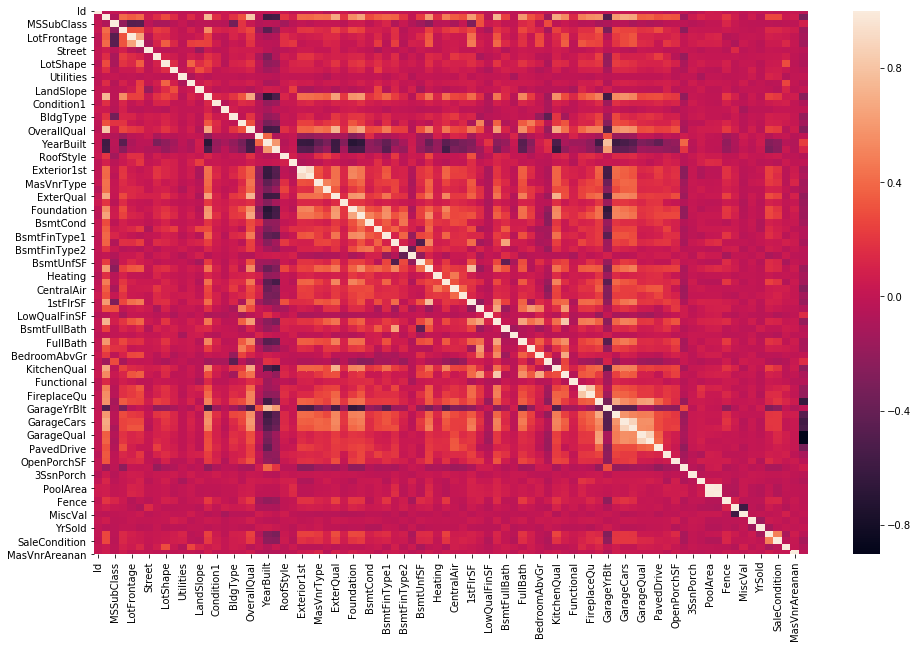

In [87]:
import seaborn as sns
fig_dims = (16,10)
fig,ax = plt.subplots(figsize = fig_dims)
sns.heatmap(corr, ax=ax)

In [ ]:
df['A'].corr(df['B'])

In [92]:
for feature in data.columns:
    if data[feature].corr(data['SalePrice'])>0.5:
        print(feature, data[feature].corr(data['SalePrice']))

SalePrice 1.0
Neighborhood 0.7399738496392305
OverallQual 0.8171844179216837
ExterQual 0.6788398348643097
Foundation 0.5496813471391524
BsmtQual 0.6477178203062735
TotalBsmtSF 0.6121339753697865
1stFlrSF 0.6089466549036315
GrLivArea 0.7302548511982293
FullBath 0.594770542007532
KitchenQual 0.667893025602166
TotRmsAbvGrd 0.5344222037231259
FireplaceQu 0.5471508190878215
GarageType 0.5736272379834287
GarageFinish 0.6048777126766777
GarageCars 0.6806248074360479
GarageArea 0.6508875559020074


In [94]:
for feature in data.columns:
    if data[feature].corr(data['SalePrice'])<-0.5:
        print(feature, data[feature].corr(data['SalePrice']))

YearBuilt -0.5872900470291367
YearRemodAdd -0.5681357285300441


In [11]:
X = data.drop(['Id','SalePrice'],axis=1)

In [12]:
best_feat= ['Neighborhood','OverallQual','ExterQual','Foundation','BsmtQual','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','KitchenQual','TotRmsAbvGrd','FireplaceQu','GarageType','GarageFinish','GarageCars','GarageArea','YearBuilt','YearRemodAdd']
y = data['SalePrice']

In [13]:
X = X[best_feat]

In [102]:
X

,Neighborhood,OverallQual,ExterQual,Foundation,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,YearBuilt,YearRemodAdd
0,0.636364,0.666667,0.666667,1.00,0.75,0.140098,0.356155,0.577712,0.666667,0.666667,0.500000,0.2,0.8,0.666667,0.50,0.386460,0.036765,0.098361
1,0.500000,0.555556,0.333333,0.50,0.75,0.206547,0.503056,0.470245,0.666667,0.333333,0.333333,0.6,0.8,0.666667,0.50,0.324401,0.227941,0.524590
2,0.636364,0.666667,0.666667,1.00,0.75,0.150573,0.383441,0.593095,0.666667,0.666667,0.333333,0.6,0.8,0.666667,0.50,0.428773,0.051471,0.114754
3,0.727273,0.666667,0.333333,0.25,0.50,0.123732,0.399941,0.579157,0.333333,0.666667,0.416667,0.8,0.4,0.333333,0.75,0.452750,0.669118,0.606557
4,1.000000,0.777778,0.666667,1.00,0.75,0.187398,0.466237,0.666523,0.666667,0.666667,0.583333,0.6,0.8,0.666667,0.75,0.589563,0.058824,0.147541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.590909,0.555556,0.333333,1.00,0.75,0.155974,0.396777,0.564433,0.666667,0.333333,0.416667,0.6,0.8,0.666667,0.50,0.324401,0.058824,0.131148
1456,0.545455,0.555556,0.333333,0.50,0.75,0.252373,0.690872,0.645810,0.666667,0.333333,0.416667,0.6,0.8,0.333333,0.50,0.352609,0.235294,0.377049
1457,0.727273,0.666667,1.000000,0.75,0.50,0.188543,0.480189,0.688669,0.666667,0.666667,0.583333,0.8,0.8,0.666667,0.25,0.177715,0.507353,0.081967
1458,0.363636,0.444444,0.333333,0.50,0.50,0.176432,0.443419,0.414497,0.333333,0.666667,0.250000,0.2,0.8,0.333333,0.25,0.169252,0.441176,0.245902


In [15]:
from sklearn.linear_model import LinearRegression

In [28]:
regressor = LinearRegression(normalize=True, n_jobs=-1)

In [29]:
regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [30]:
print(regressor.score(X_test, y_test)) 

0.8068555709872409


In [31]:
y_pred = regressor.predict(X_test)

In [32]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.11114645205413567
Mean Squared Error: 0.02924203601366808
Root Mean Squared Error: 0.17100302925289973


In [33]:
test_data = pd.read_csv('test_modified.csv')

In [34]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontagenan,MasVnrAreanan,BsmtFullBathnan,BsmtHalfBathnan,GarageYrBltnan
0,1461,0.000000,0.25,0.593445,0.566360,1.0,0.5,0.666667,0.000000,1.0,...,0.000000,0.454545,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
1,1462,0.000000,0.50,0.598957,0.622527,1.0,0.5,0.333333,0.000000,1.0,...,0.735294,0.454545,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
2,1463,0.235294,0.50,0.558854,0.614005,1.0,0.5,0.333333,0.000000,1.0,...,0.000000,0.181818,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
3,1464,0.235294,0.50,0.582212,0.524583,1.0,0.5,0.333333,0.000000,1.0,...,0.000000,0.454545,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
4,1465,0.588235,0.50,0.317987,0.335596,1.0,0.5,0.333333,0.666667,1.0,...,0.000000,0.000000,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X_test2 = test_data.drop(['Id','BsmtFullBathnan','BsmtHalfBathnan'],axis=1)

In [36]:
#X_test2.shape, X_train.shape
X_test2 = X_test2[best_feat]

In [37]:
X_test2

,Neighborhood,OverallQual,ExterQual,Foundation,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,YearBuilt,YearRemodAdd
0,0.45,0.444444,1.000000,0.25,0.75,0.173111,0.312253,0.312253,0.25,0.75,0.166667,0.6,0.333333,0.666667,0.2,0.490591,0.384615,0.822581
1,0.45,0.555556,1.000000,0.25,0.75,0.260844,0.468253,0.468253,0.25,0.50,0.250000,0.6,0.333333,0.666667,0.2,0.209677,0.407692,0.870968
2,0.00,0.444444,1.000000,0.00,0.25,0.182139,0.326139,0.548792,0.50,0.75,0.250000,0.2,0.333333,0.000000,0.4,0.323925,0.107692,0.225806
3,0.00,0.555556,1.000000,0.00,0.75,0.181747,0.325285,0.542672,0.50,0.50,0.333333,0.0,0.333333,0.000000,0.4,0.315860,0.100000,0.225806
4,0.55,0.777778,0.666667,0.00,0.25,0.251227,0.453388,0.453388,0.50,0.50,0.166667,0.6,0.333333,0.333333,0.4,0.340054,0.146154,0.322581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.00,0.333333,1.000000,0.25,0.75,0.107164,0.116257,0.390532,0.25,0.75,0.166667,0.6,0.666667,1.000000,0.0,0.000000,0.284615,0.612903
1455,1.00,0.333333,1.000000,0.25,0.75,0.107164,0.116257,0.390532,0.25,0.75,0.250000,0.6,0.833333,0.666667,0.2,0.192204,0.284615,0.612903
1456,0.70,0.444444,1.000000,0.25,0.75,0.240236,0.435686,0.435686,0.25,0.75,0.333333,0.2,0.500000,0.666667,0.4,0.387097,0.361538,0.193548
1457,0.70,0.444444,1.000000,0.00,0.25,0.178999,0.343654,0.343654,0.25,0.75,0.250000,0.6,0.666667,1.000000,0.0,0.000000,0.115385,0.258065


In [38]:
#X_test2 = X_test2[selected_feat]

In [39]:
y_pred2=regressor.predict(X_test2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [119]:
y_pred2

array([11.843879, 12.084364, 12.020485, ..., 12.124265, 11.81609 ,
       12.376834], dtype=float32)

In [120]:
y_pred2 = np.exp(y_pred2)

In [121]:
y_pred2

array([139229.47, 177081.25, 166123.19, ..., 184289.78, 135413.67,
       237241.5 ], dtype=float32)

In [123]:
output = pd.DataFrame({'Id': test_data['Id'], 'Saleprice': y_pred2})
output.to_csv('fifth_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
from sklearn.model_selection import RandomizedSearchCV

In [42]:
regressor = RandomForestRegressor()

In [43]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [44]:
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=random_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [45]:
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  7.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [46]:
random_cv.best_estimator_, random_cv.best_params_

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False),
 {'n_estimators': 400,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 30,
  'bootstrap': True})

In [47]:
regressor=RandomForestRegressor(n_estimators=400,min_samples_split=5,min_samples_leaf=1,max_features='sqrt',max_depth=30,bootstrap=True)

In [48]:
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
y_pred = regressor.predict(X_test)

In [50]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
529,12.209188,12.407940
491,11.798104,11.781546
459,11.608236,11.684601
279,12.165251,12.317554
655,11.385092,11.435804
...,...,...
326,12.688499,12.420436
440,13.226723,13.020152
1387,11.820410,11.993633
1323,11.320554,11.032354


In [51]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.09810810341033525
Mean Squared Error: 0.01915664804671834
Root Mean Squared Error: 0.13840754331581187


In [52]:
X_test2 = test_data.drop(['Id','BsmtFullBathnan','BsmtHalfBathnan'],axis=1)

In [53]:
#X_test2.shape, X_train.shape
#X_test2 = X_test2[best_feat]
X_test2 = X_test2[selected_feat]

In [54]:
X_test2

,Neighborhood,OverallQual,ExterQual,Foundation,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,YearBuilt,YearRemodAdd
0,0.45,0.444444,1.000000,0.25,0.75,0.173111,0.312253,0.312253,0.25,0.75,0.166667,0.6,0.333333,0.666667,0.2,0.490591,0.384615,0.822581
1,0.45,0.555556,1.000000,0.25,0.75,0.260844,0.468253,0.468253,0.25,0.50,0.250000,0.6,0.333333,0.666667,0.2,0.209677,0.407692,0.870968
2,0.00,0.444444,1.000000,0.00,0.25,0.182139,0.326139,0.548792,0.50,0.75,0.250000,0.2,0.333333,0.000000,0.4,0.323925,0.107692,0.225806
3,0.00,0.555556,1.000000,0.00,0.75,0.181747,0.325285,0.542672,0.50,0.50,0.333333,0.0,0.333333,0.000000,0.4,0.315860,0.100000,0.225806
4,0.55,0.777778,0.666667,0.00,0.25,0.251227,0.453388,0.453388,0.50,0.50,0.166667,0.6,0.333333,0.333333,0.4,0.340054,0.146154,0.322581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.00,0.333333,1.000000,0.25,0.75,0.107164,0.116257,0.390532,0.25,0.75,0.166667,0.6,0.666667,1.000000,0.0,0.000000,0.284615,0.612903
1455,1.00,0.333333,1.000000,0.25,0.75,0.107164,0.116257,0.390532,0.25,0.75,0.250000,0.6,0.833333,0.666667,0.2,0.192204,0.284615,0.612903
1456,0.70,0.444444,1.000000,0.25,0.75,0.240236,0.435686,0.435686,0.25,0.75,0.333333,0.2,0.500000,0.666667,0.4,0.387097,0.361538,0.193548
1457,0.70,0.444444,1.000000,0.00,0.25,0.178999,0.343654,0.343654,0.25,0.75,0.250000,0.6,0.666667,1.000000,0.0,0.000000,0.115385,0.258065


In [55]:
#X_test2 = X_test2[selected_feat]

In [56]:
y_pred2=regressor.predict(X_test2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [119]:
y_pred2

array([11.843879, 12.084364, 12.020485, ..., 12.124265, 11.81609 ,
       12.376834], dtype=float32)

In [120]:
y_pred2 = np.exp(y_pred2)

In [121]:
y_pred2

array([139229.47, 177081.25, 166123.19, ..., 184289.78, 135413.67,
       237241.5 ], dtype=float32)

In [123]:
output = pd.DataFrame({'Id': test_data['Id'], 'Saleprice': y_pred2})
output.to_csv('fifth_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [105]:
## Hyper Parameter Optimization


n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [106]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)